In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from catboost import CatBoostRegressor, Pool
from google.cloud import storage
import os
from io import StringIO, BytesIO
from itertools import islice


In [2]:
def load_test_sets():
    client = storage.Client()
    bucket = client.get_bucket('price-estimation')
    blob_test = bucket.get_blob('data/train_test_sets/test_02032024.csv')
    blob_test_processed = bucket.get_blob('data/train_test_sets/processed_test_set_DROP_UNPRACTICAL.csv.csv')
    test_bytes = blob_test.download_as_bytes()
    test_processed_bytes = blob_test_processed.download_as_bytes()
    test = pd.read_csv(BytesIO(test_bytes), index_col=0)
    processed_test = pd.read_csv(BytesIO(test_processed_bytes), index_col=0)
    return test, processed_test

In [24]:
def load_results():
    client = storage.Client()
    bucket = client.get_bucket('price-estimation')
    blob = bucket.get_blob('data/results/results_drop_unpractical.csv')
    res_bytes = blob.download_as_bytes()
    results = pd.read_csv(BytesIO(res_bytes), index_col=0)
    return results

In [4]:
def load_model(name):
    client = storage.Client()
    bucket = client.get_bucket('price-estimation')
    blob_cb = bucket.get_blob(f'models/{name}.cbm')
    cb_name = f"{name}.cbm"
    blob_cb.download_to_filename(cb_name)
    cb = CatBoostRegressor().load_model(cb_name)
    return cb

In [5]:
def get_set_for_prediction(df):
    df = df.copy()
    X, y = df.drop(columns=['raw_price']), df['raw_price']
    categorical_features = [X.columns.get_loc(x) for x in
                          X.select_dtypes(include=['object', 'category', 'int', 'bool']).columns.tolist()]
    X.iloc[:,categorical_features] = X.iloc[:,categorical_features].fillna("nan").copy()
    pool = Pool(data=X, label=y, cat_features=categorical_features)
    return pool

In [6]:
test, test_procesed = load_test_sets()
cb2 = load_model('catboost_q2')
cb1 = load_model('catboost_q1')
cb3 = load_model('catboost_q3')

In [7]:
test_pool = get_set_for_prediction(test_procesed)

In [8]:
test['pred_q1'] = cb1.predict(test_pool)
test['pred_q2'] = cb2.predict(test_pool)
test['pred_q3'] = cb3.predict(test_pool)

In [9]:
test.loc[test.pred_q1 >= test.pred_q3, 'pred_q2'].shape[0]/test.shape[0]

0.008232278418613822

In [10]:
test.loc[(test.pred_q2 >= test.pred_q3) | ((test.pred_q2 <= test.pred_q1)), 'pred_q2'].shape[0]/test.shape[0]

0.09647047224686976

In [11]:
test['brand_count'] = test.groupby('brand')['raw_price'].transform('count')
test['brand_model_count'] = test.groupby(['brand','model'])['raw_price'].transform('count')
test['brand_model_year_count'] = test.groupby(['brand','model','registration_year'])['raw_price'].transform('count')

<Axes: ylabel='Frequency'>

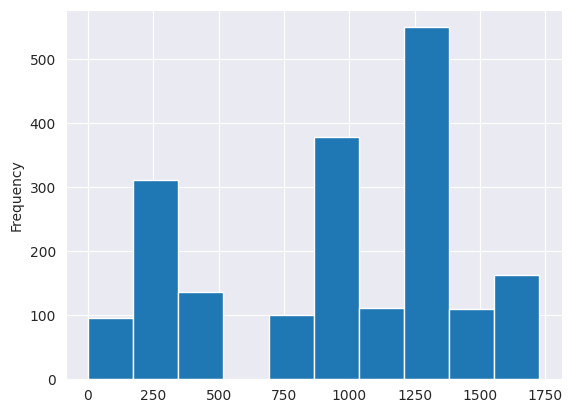

In [12]:
test.loc[(test.pred_q2 >= test.pred_q3) | ((test.pred_q2 <= test.pred_q1))].brand_count.plot(kind='hist')

<Axes: ylabel='Frequency'>

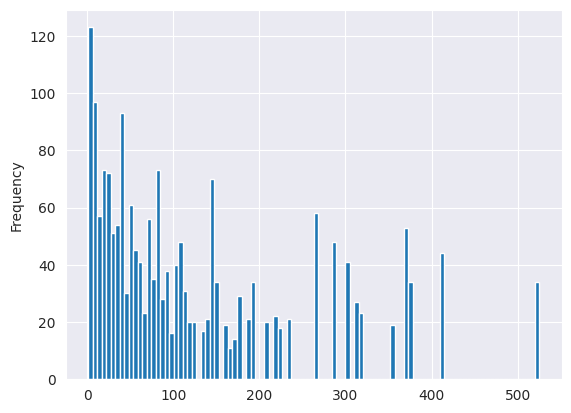

In [13]:
test.loc[(test.pred_q2 >= test.pred_q3) | ((test.pred_q2 <= test.pred_q1))].brand_model_count.plot(kind='hist',bins=100)

<Axes: ylabel='Frequency'>

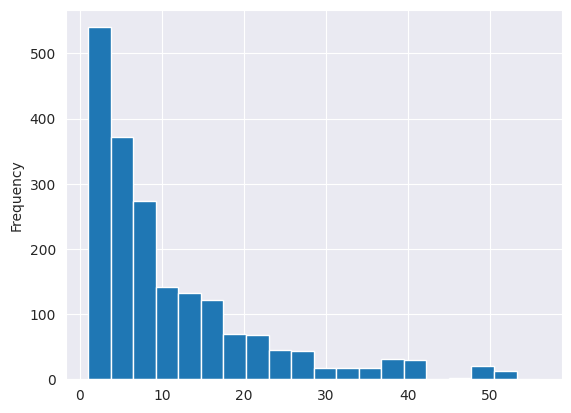

In [14]:
test.loc[(test.pred_q2 >= test.pred_q3) | ((test.pred_q2 <= test.pred_q1))].brand_model_year_count.plot(kind='hist',bins=20)

In [15]:
# We see that anomalies in the q1,q2,q3 preds occur for sparse car brand and models in the data

In [15]:
test['pred_q1_old'] = test.pred_q1
test['pred_q3_old'] = test.pred_q3

In [16]:
test.loc[test.pred_q1 >= test.pred_q3, 'pred_q1'] = test.loc[test.pred_q1 >= test.pred_q3, 'pred_q3_old']
test.loc[test.pred_q1 >= test.pred_q3, 'pred_q3'] = test.loc[test.pred_q1 >= test.pred_q3, 'pred_q1_old']
test.loc[test.pred_q1 >= test.pred_q3, 'pred_q2'] = (test.loc[test.pred_q1 >= test.pred_q3, 'pred_q1'] + test.loc[test.pred_q1 >= test.pred_q3, 'pred_q3'])/2

test.loc[(test.pred_q2 >= test.pred_q3) | ((test.pred_q2 <= test.pred_q1)), 'pred_q2'] = (test.loc[(test.pred_q2 >= test.pred_q3) | ((test.pred_q2 <= test.pred_q1)), 'pred_q1'] + test.loc[(test.pred_q2 >= test.pred_q3) | ((test.pred_q2 <= test.pred_q1)), 'pred_q3'])/2


In [17]:
test['uncertainty'] = (test.pred_q3 - test.pred_q1)/test.pred_q2

In [18]:
qs = [0.01,0.05,0.25,0.5,0.75,0.9,0.95,0.99]

In [19]:
test.uncertainty.describe(qs)

count    20286.000000
mean         0.187194
std          0.167349
min          0.000024
1%           0.013110
5%           0.041784
25%          0.098493
50%          0.151203
75%          0.234060
90%          0.341853
95%          0.433167
99%          0.691459
max          9.807750
Name: uncertainty, dtype: float64

(0.0, 1.0)

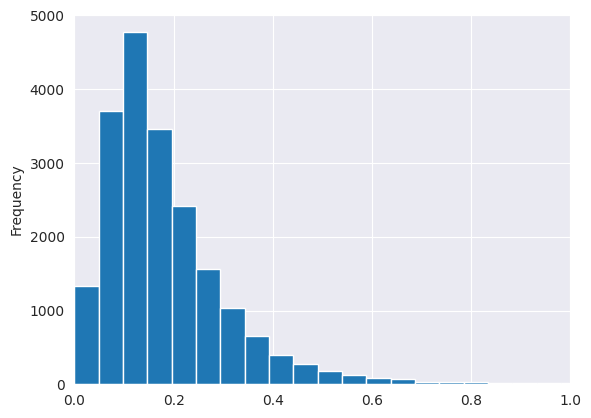

In [21]:
test.uncertainty.plot(kind='hist', bins=200)
plt.xlim([0,1])

(0.0, 1.0)

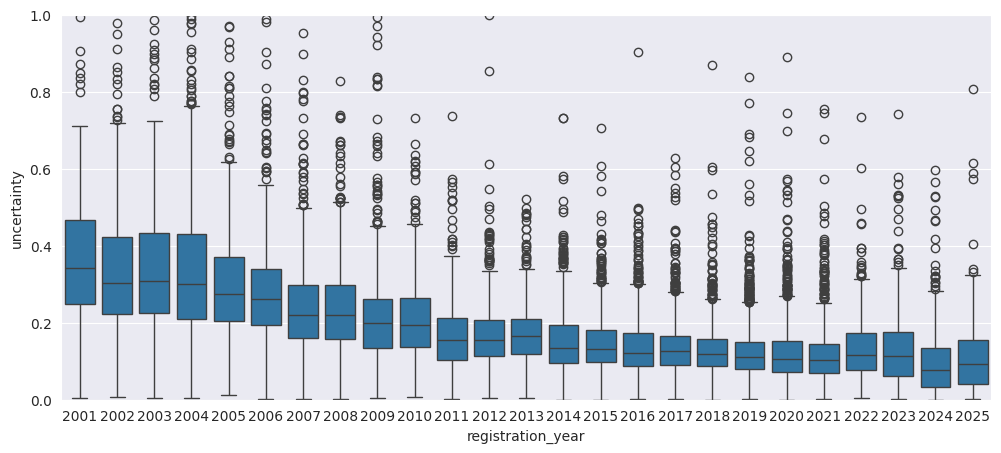

In [22]:
plt.figure(figsize=(12,5))
sns.boxplot(x=test.registration_year, y=test.uncertainty)
plt.ylim([0,1])



(0.0, 200000.0)

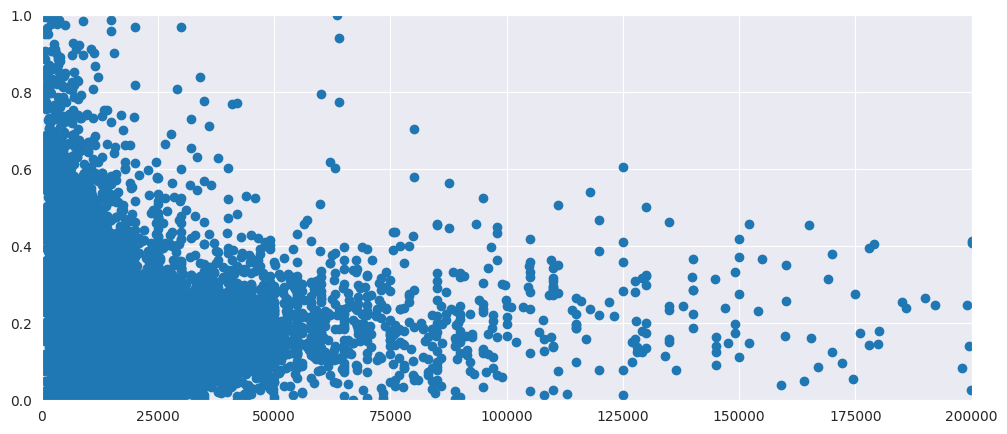

In [23]:
plt.figure(figsize=(12,5))
plt.scatter(test.raw_price, test.uncertainty)
plt.ylim([0,1])
plt.xlim([0,200000])

(0.0, 500000.0)

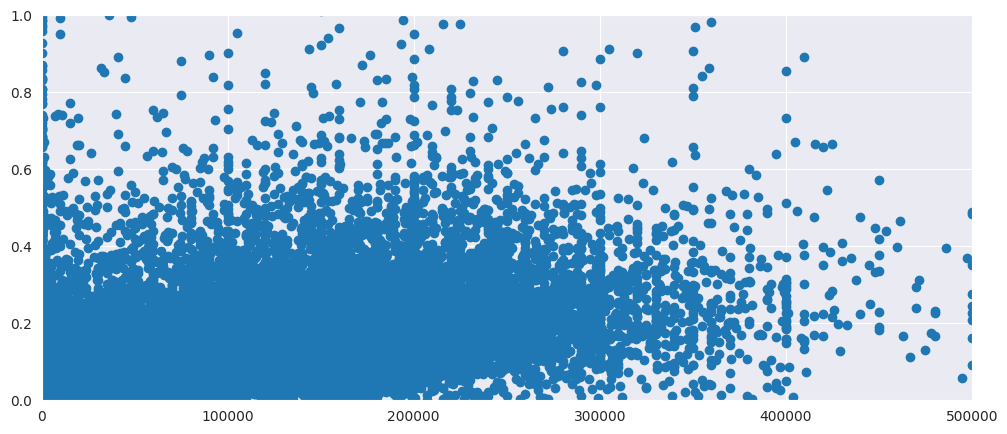

In [24]:
plt.figure(figsize=(12,5))
plt.scatter(test.mileage, test.uncertainty)
plt.ylim([0,1])
plt.xlim([0,500000])

(0.0, 1.0)

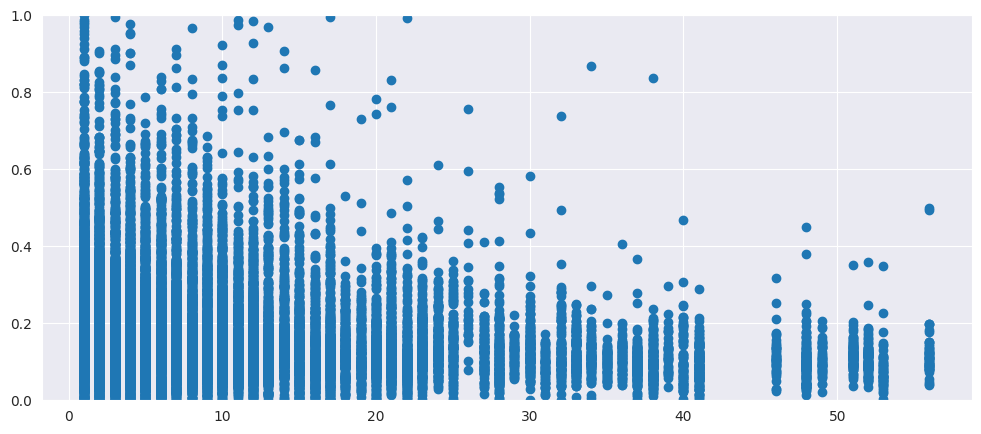

In [25]:
plt.figure(figsize=(12,5))
plt.scatter(test.brand_model_year_count, test.uncertainty)
plt.ylim([0,1])

In [25]:
results = load_results()

In [26]:
results.columns

Index(['id', 'residuals_drop_unpractical', 'abs_residuals_drop_unpractical',
       'ape_drop_unpractical'],
      dtype='object')

In [37]:
test['ape'] = results.ape_drop_unpractical
test['residuals'] = results.residuals_drop_unpractical

(0.0, 1.0)

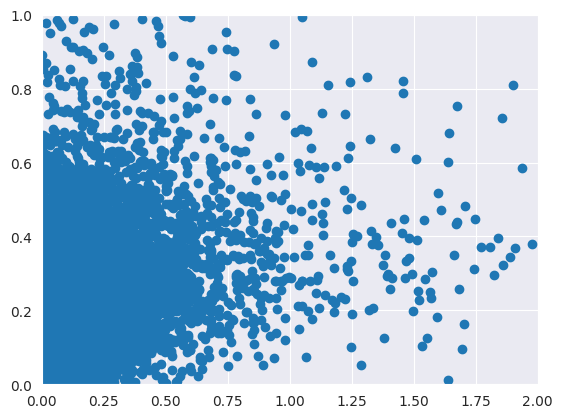

In [28]:
plt.scatter(test.ape, test.uncertainty)
plt.xlim([0,2])
plt.ylim([0,1])

In [30]:
mean_reliability = np.mean(test.uncertainty)

In [29]:
def reliability_score(uncertainty,central_uncertainty,lamda):
    return 1 - 1/(1 + np.exp(-lamda*(uncertainty - central_uncertainty )))

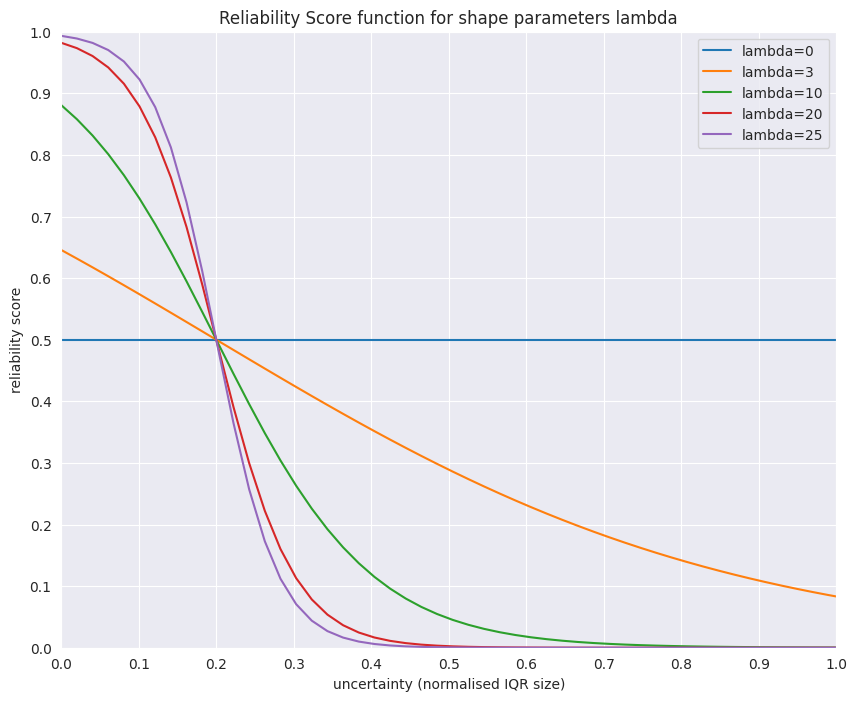

In [44]:
xs = np.linspace(0,2,100)
lamdas = [0,3,10, 20, 25]
plt.figure(figsize=(10,8))
for i in lamdas:
    plt.plot(xs, reliability_score(xs, 0.2, i), label=f"lambda={str(i)}")
plt.legend()
plt.ylim([0,1])
plt.xlim([0,1])
plt.xlabel("uncertainty (normalised IQR size)")
plt.ylabel("reliability score")
plt.xticks(np.linspace(0, 1, 11))  # 20 ticks on x-axis
plt.yticks(np.linspace(0, 1, 11))
plt.title("Reliability Score function for shape parameters lambda")
plt.savefig("../plots/reliability_score.png")

In [113]:
print(reliability_score(0.05, 0.2, 20))
print(reliability_score(0.15, 0.2, 20))

0.9525741268224333
0.731058578630005


In [30]:
test['final_uncertainty'] = test.uncertainty.apply(lambda x : reliability_score(x, 0.2,20))

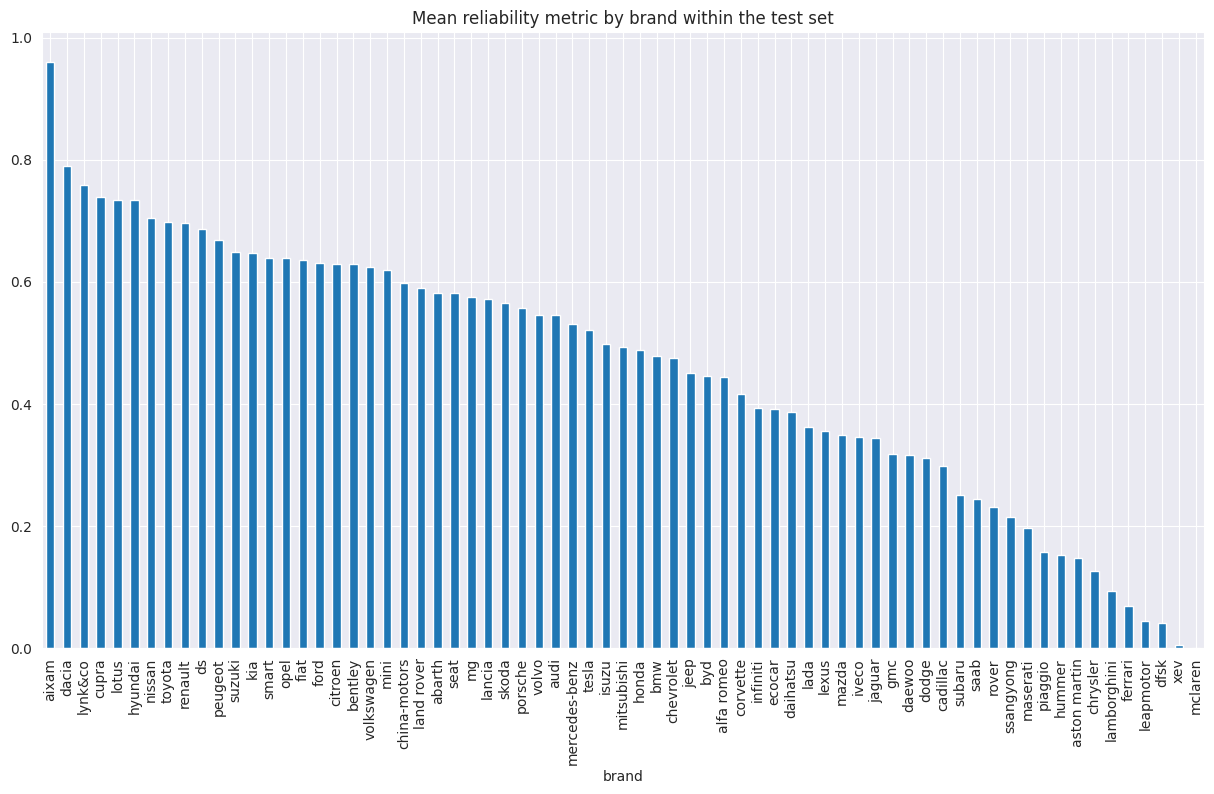

In [119]:
plt.figure(figsize=(15,8))
test.groupby('brand')['final_uncertainty'].agg('mean').sort_values(ascending=False).plot(kind='bar')
plt.title('Mean reliability metric by brand within the test set')
plt.savefig('../plots/reliability_by_brand.png', bbox_inches='tight')


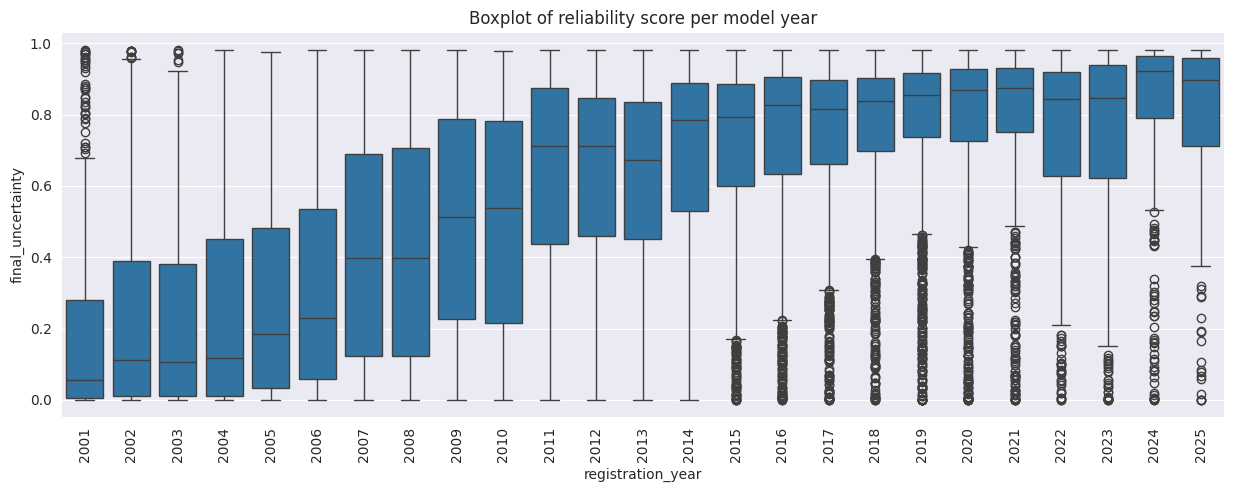

In [124]:
plt.figure(figsize=(15,5))
sns.boxplot(test,y='final_uncertainty', x='registration_year')
plt.xticks(rotation=90)
plt.title('Boxplot of reliability score per model year')
plt.savefig('../plots/boxplot_reliability_per_year.png', bbox_inches='tight')

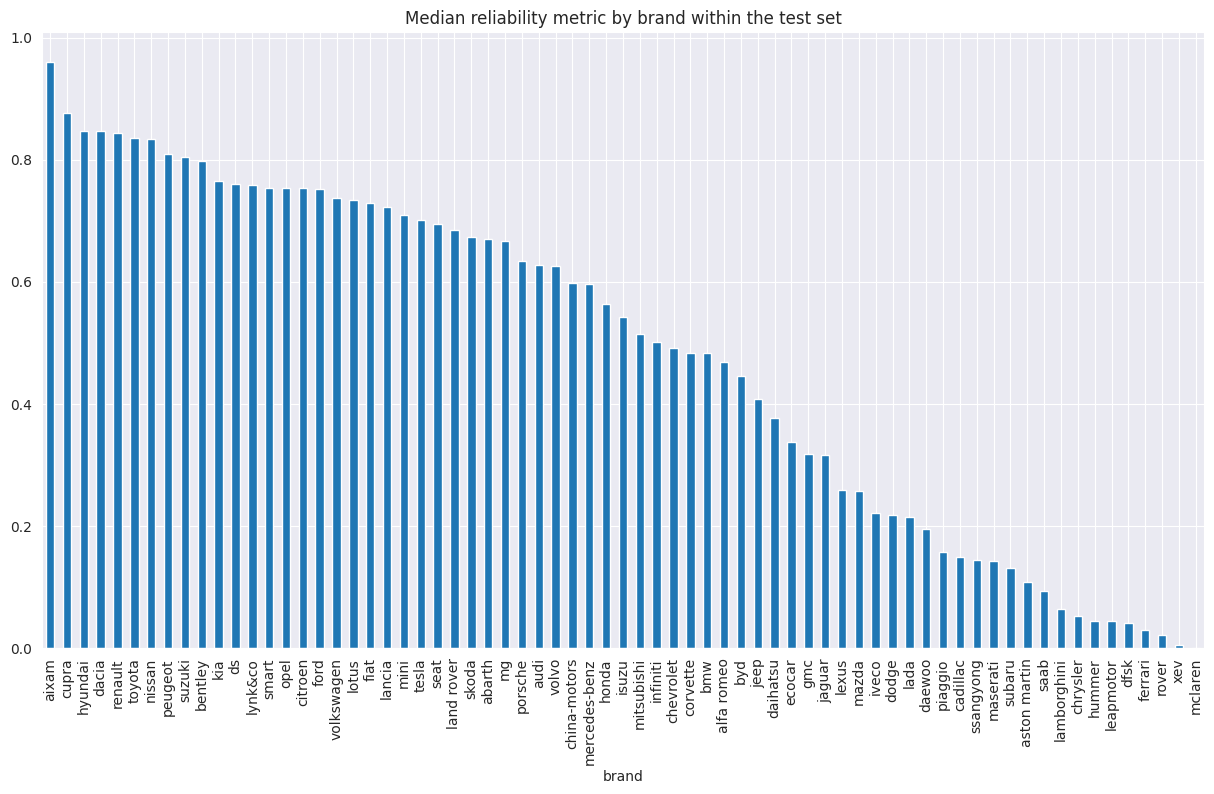

In [31]:
plt.figure(figsize=(15,8))
test.groupby('brand')['final_uncertainty'].agg('median').sort_values(ascending=False).plot(kind='bar')
plt.title('Median reliability metric by brand within the test set')
plt.savefig('../plots/reliability_by_brand_median.png', bbox_inches='tight')


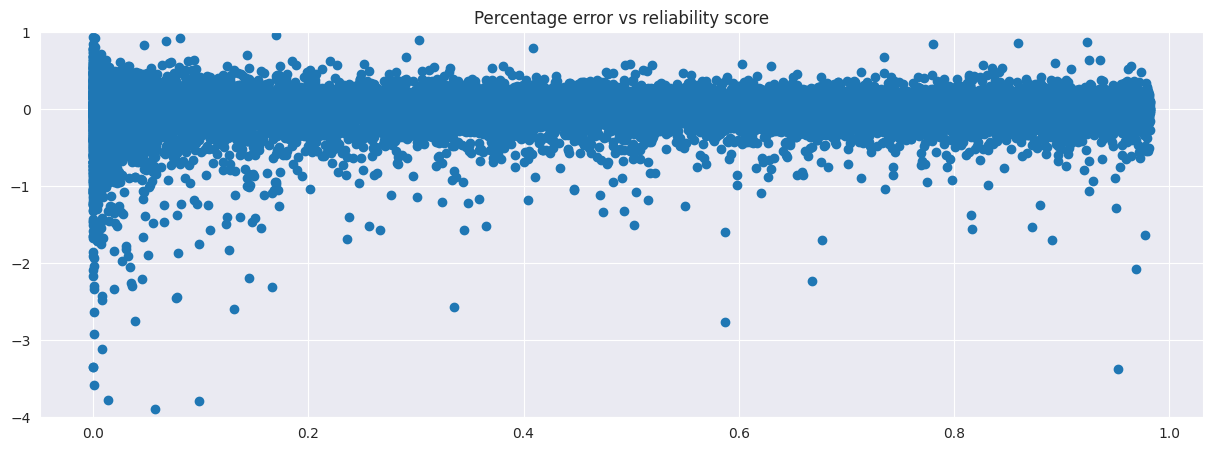

In [50]:
plt.figure(figsize=(15,5))
plt.scatter(test.final_uncertainty, test.ape*test.residuals.apply(np.sign))
plt.ylim([-4,1])
plt.title('Percentage error vs reliability score')
plt.savefig('../plots/reliability_error.png', bbox_inches='tight')




Text(0.5, 1.0, 'Distribution of Reliability Score')

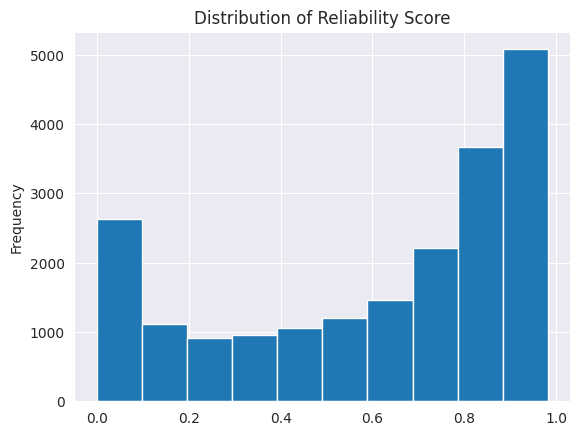

In [35]:
test.final_uncertainty.plot(kind='hist')
plt.title('Distribution of Reliability Score')

In [126]:
test.final_uncertainty.describe()

count    20286.000000
mean         0.605492
std          0.323516
min          0.000000
25%          0.335995
50%          0.726302
75%          0.883925
max          0.982005
Name: final_uncertainty, dtype: float64

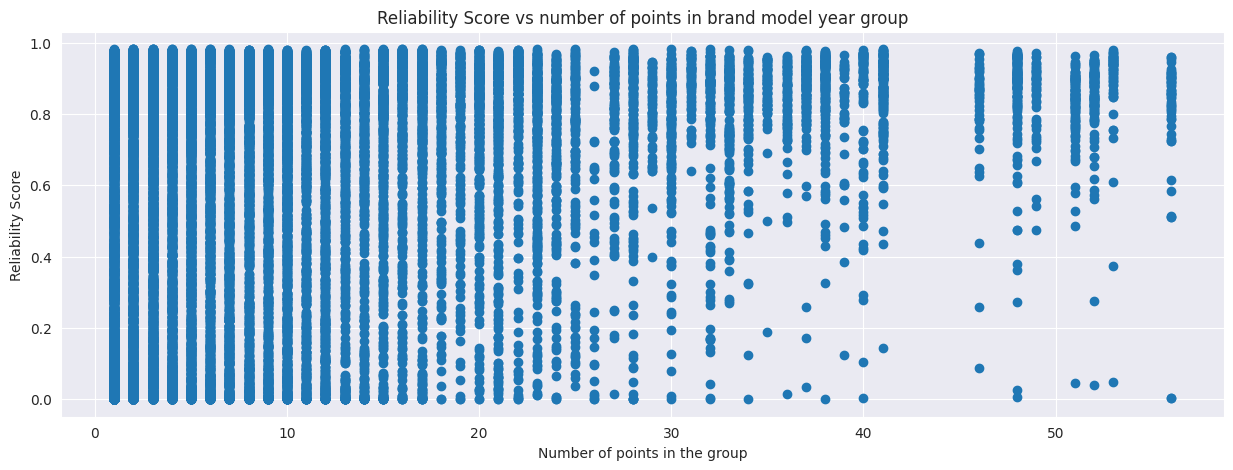

In [51]:
plt.figure(figsize=(15,5))
plt.scatter(test.brand_model_year_count, test.final_uncertainty)
plt.xlabel('Number of points in the group')
plt.ylabel('Reliability Score')
plt.title('Reliability Score vs number of points in brand model year group')
plt.savefig('../plots/reliability_count.png', bbox_inches='tight')

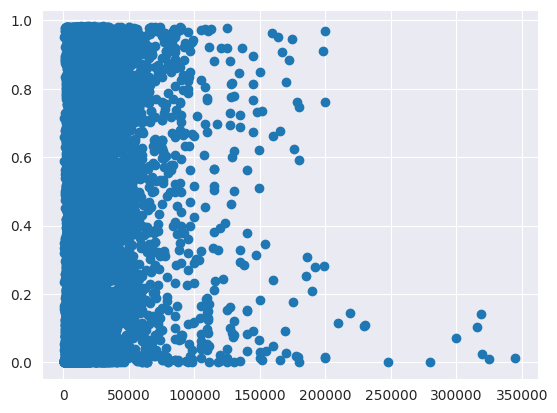

In [129]:
plt.scatter(test.raw_price,test.final_uncertainty)

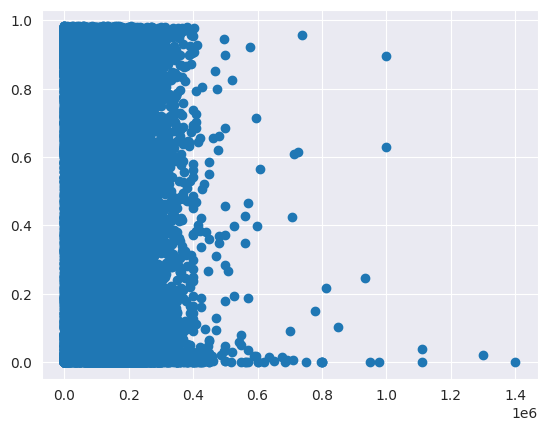

In [130]:
plt.scatter(test.mileage,test.final_uncertainty)

Text(0.5, 1.0, 'Absolute Pct Error vs Reliability Score')

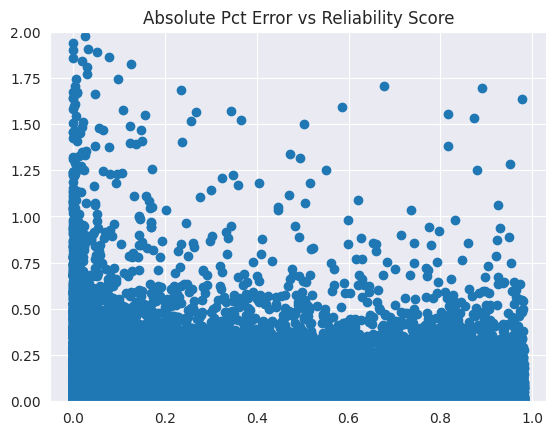

In [52]:
plt.scatter(test.final_uncertainty,test.ape)
plt.ylim([0,2])
plt.title('Absolute Pct Error vs Reliability Score')

In [145]:
def pdp_num(row,X_test_set, feature, models):
    min_val = X_test_set[feature].min()
    max_val = X_test_set[feature].max()
    new_set = X_test_set.copy()
    range_vals = np.linspace(min_val,max_val,20)
    predictions_q1 = []
    predictions_q2 = []
    predictions_q3 = []

    for val in range_vals:
        row[feature] = val
        pred1 = models[0].predict(row)
        pred2 = models[1].predict(row)
        pred3 = models[2].predict(row)
        predictions_q1.append(pred1)
        predictions_q2.append(pred2)
        predictions_q3.append(pred3)
    plt.plot(range_vals, predictions_q2, label="Estimated price")
    plt.fill_between(range_vals, predictions_q1, predictions_q3,color='blue', alpha=0.2, label='Estimated Price Range')
    plt.title('PDP for feature {}'.format(feature))






In [143]:
def get_set_for_prediction_(df):
    df = df.copy()
    X, y = df.drop(columns=['raw_price']), df['raw_price']
    categorical_features = [X.columns.get_loc(x) for x in
                          X.select_dtypes(include=['object', 'category', 'int', 'bool']).columns.tolist()]
    X.iloc[:,categorical_features] = X.iloc[:,categorical_features].fillna("nan").copy()
    return X

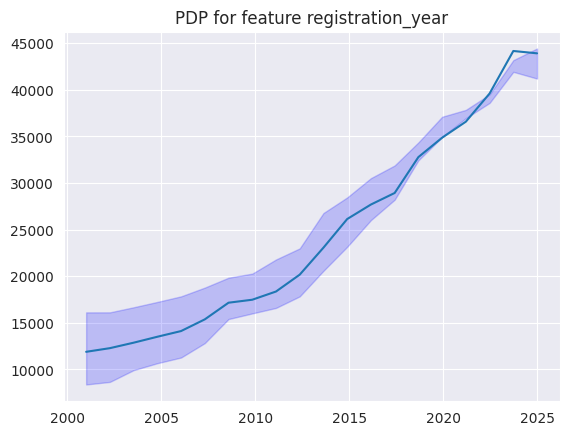

In [173]:
pdp_num(get_set_for_prediction_(test_procesed).iloc[0],test,'registration_year',[cb1,cb2,cb3])

In [171]:
def pdp_cat(row, X_test_set, feature, models):
    new_set = X_test_set.copy()
    range_vals = new_set[feature].unique()
    predictions_q1 = []
    predictions_q2 = []
    predictions_q3 = []
    vals = []
    for val in range_vals:
        row[feature] = val
        pred_q1 = models[0].predict(row)
        pred_q2 = models[1].predict(row)
        pred_q3 = models[2].predict(row)
        predictions_q1.append(pred_q1)
        predictions_q2.append(pred_q2)
        predictions_q3.append(pred_q3)
        vals.append(str(val))
    df = pd.DataFrame({'cats':vals, 'pred_q1': predictions_q1, 'pred_q2':predictions_q2, 'pred_q3':predictions_q3}).sort_values(by='pred_q2', ascending=False)
    plt.scatter(np.arange(df.cats.shape[0]), df.pred_q2)
    plt.fill_between(np.arange(df.cats.shape[0]), df.pred_q1, df.pred_q3, alpha=0.2, color='blue')
    plt.xticks(np.arange(df.cats.shape[0]), df.cats, rotation = 60, fontsize=5)
    plt.title('PDP for feature {}'.format(feature))

In [176]:
pdp_cat(get_set_for_prediction_(test_procesed).iloc[0], test, 'interior_color', [cb1,cb2,cb3])

CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=73]=nan : cat_features must be integer or string, real number values and NaN values should be converted to string.